# Further Model Development and Fine-tuning
Daniel Sery 

# Import and Setup

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

from tensorflow import keras
from tensorflow.keras import layers, regularizers  ### Adding 'regularizers'
from tensorflow.keras.models import Sequential
import pathlib
import zipfile



2024-12-08 12:15:59.969120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733678160.322195  564197 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733678160.451695  564197 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 12:16:01.310930: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Specify the path to the zip file
dataset_url = "https://dl.dropboxusercontent.com/scl/fi/mrsbiu74dh3h3i0j2xi8b/ls_model_data_five.zip?rlkey=in4z2twssi71adfi1exknm67w&dl=0?raw=1"

In [6]:
#dataset_name = 'ls_model_data_five'
#savepath = os.path.join(os.path.expanduser("~"), ".keras", "datasets", dataset_name)
#savepath

In [14]:
data_dir = tf.keras.utils.get_file('ls_model_data_five.zip', origin=dataset_url, extract=True,
                                   #cache_dir=savepath
                                  )
data_dir = pathlib.Path(data_dir).with_suffix('')

In [15]:
data_dir

PosixPath('/home/dms3gv/.keras/datasets/ls_model_data_five')

In [16]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6974


In [17]:
folders = [folder for folder in data_dir.glob('*') if folder.is_dir()]
print("Folders in the dataset directory:")
for folder in folders:
    print(folder.name)

Folders in the dataset directory:
landslide
non_landslide


In [18]:
# Drill into each subdirectory and list counts per folder
for folder in folders:
    print(f"\nContents of folder '{folder.name}':")
    # for subitem in folder.iterdir():
    count = len(list(folder.glob('*.jpg')))
    print(f"{folder.name}: {count} .jpg images")


Contents of folder 'landslide':
landslide: 3034 .jpg images

Contents of folder 'non_landslide':
non_landslide: 3940 .jpg images


## Helper

In [19]:
## Resize and Printer Helper
def resize_show(image_path):
    img = tf.keras.utils.load_img(
        image_path, target_size=(500,500)
    )
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    plt.imshow(img)
    plt.axis('off')  # Optional: turn off the axis
    plt.show()

### Review an image:

I0000 00:00:1733678575.881216  564197 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38251 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0


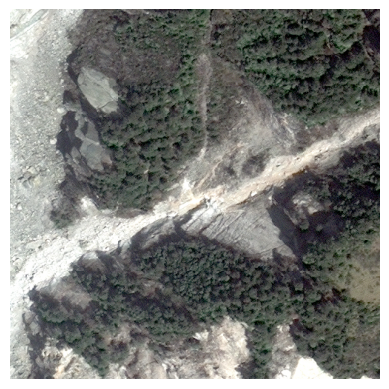

In [20]:
landslide_one = list(data_dir.glob('landslide/*'))
# PIL.Image.open(str(landslide_one[50]))
resize_show(landslide_one[150])

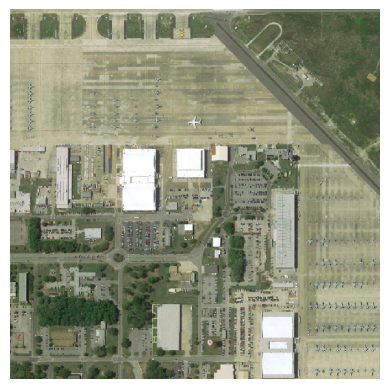

In [21]:
# landslide_one = list(data_dir.glob('landslide/*'))
# PIL.Image.open(str(landslide_one[0]))

non_landslide_img = list(data_dir.glob('non_landslide/*'))
# PIL.Image.open(str(non_landslide_img[1]))
resize_show(non_landslide_img[120])

## Separate Test Set

In [22]:
#https://www.dropbox.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0
# test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0?raw=1"

#test_dataset_url = 'https://dl.dropboxusercontent.com/s/0en4k86c1r1uzs0/test_google_images_landslides_four.zip?st=pdg6yhzj&dl=0?raw=1'
test_dataset_url = 'https://dl.dropboxusercontent.com/scl/fi/kl3e9wxoibqu0ldogwxg0/test_google_images_landslides_five.zip?rlkey=zuhh6xvjy3oi9wuroy4ogtdi3&dl=0?raw=1'

In [23]:
from urllib.parse import urlparse
file_name = os.path.basename(urlparse(test_dataset_url).path)
base_name = os.path.splitext(file_name)[0]

In [24]:
dataset_name = base_name
savepath = os.path.join(os.path.expanduser("~"), ".keras", "datasets", dataset_name)
savepath

'/home/dms3gv/.keras/datasets/test_google_images_landslides_five'

In [25]:
data_dir_test = tf.keras.utils.get_file(file_name, origin=test_dataset_url, extract=True,
                                       #cache_dir = savepath
                                       )
data_dir_test = pathlib.Path(data_dir_test).with_suffix('')

In [26]:
data_dir_test

PosixPath('/home/dms3gv/.keras/datasets/test_google_images_landslides_five')

In [27]:
## Review folders in incoming data / classes
folders = [folder for folder in data_dir_test.glob('*') if folder.is_dir()]
print("Folders in the test directory:")
for folder in folders:
    print(folder.name)

Folders in the test directory:
Google_Earth_Images
Test_Images_Duplicates


In [28]:
# Drill into each subdirectory and list files
for folder in folders:
    print(f"\nContents of folder '{folder.name}':")
    for subitem in folder.iterdir():
        if subitem.is_file():
            print(f"  File: {subitem.name}")
        elif subitem.is_dir():
            print(f"  Subfolder: {subitem.name}")
            count = len(list(subitem.glob('*.jpg')))
            print(f"{subitem.name}: {count} .jpg images")


Contents of folder 'Google_Earth_Images':
  Subfolder: landslides
landslides: 65 .jpg images
  Subfolder: non-landslides
non-landslides: 77 .jpg images
  File: .DS_Store

Contents of folder 'Test_Images_Duplicates':
  File: nasa_g_4263m_12654_2023_cat.jpg
  File: nasa_g_3015m_12654_2023_cat.jpg
  File: nasa_g_4161m_11542_2021_cat.jpg
  File: nasa_g_2785m_11542_2021_cat_town.jpg
  File: nasa_g_4800m_10029_2019_vylg.jpg
  File: nasa_g_4800m_9304_2017_vylg.jpg
  File: nasa_g_4250m_12699_2019_large_v2.jpg


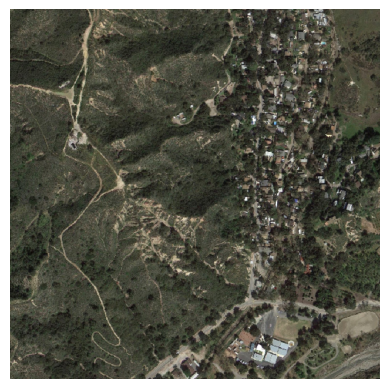

In [29]:
## Review an image
test_one = list(data_dir_test.glob('Google_Earth_Images/landslides/*'))
# PIL.Image.open(str(test_one[2]))
resize_show(test_one[25])

## **Create the model dataset**

In [30]:
## Add new Import package to chunk above.  
## from collections import Counter
## from sklearn.utils.class_weight import compute_class_weight

In [31]:
## Set Batch and Image size. 
batch_size = 32
img_height = 300
img_width = 300

#### Create Training / Validation Sets

In [32]:
## Set Training Set image set. 
train_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.20,
  subset="training",
  seed=512,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6974 files belonging to 2 classes.
Using 5580 files for training.


In [33]:
## Setup Valiation set.
valid_dataset = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.20,
  subset="validation",
  seed=512,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6974 files belonging to 2 classes.
Using 1394 files for validation.


In [34]:
# Count the total samples in training and validation sets
train_count = sum(1 for _ in train_dataset.unbatch())
valid_count = sum(1 for _ in valid_dataset.unbatch())

# Initialize class counters
train_class_counts = {}
valid_class_counts = {}

# Function to count samples per class
def count_classes(dataset, class_counts):
    for _, labels in dataset.unbatch():
        label = int(labels.numpy())
        if label not in class_counts:
            class_counts[label] = 0
        class_counts[label] += 1

# Count samples in training and validation datasets
count_classes(train_dataset, train_class_counts)
count_classes(valid_dataset, valid_class_counts)

# Display counts
print(f"Training set size: {train_count}")
print(f"Validation set size: {valid_count}")
print("\nClass distribution in Training set:")
for class_label, count in sorted(train_class_counts.items()):
    print(f"  Class {class_label}: {count} samples")

print("\nClass distribution in Validation set:")
for class_label, count in sorted(valid_class_counts.items()):
    print(f"  Class {class_label}: {count} samples")

2024-12-08 12:23:08.924578: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-08 12:23:10.432552: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training set size: 5580
Validation set size: 1394

Class distribution in Training set:
  Class 0: 2428 samples
  Class 1: 3152 samples

Class distribution in Validation set:
  Class 0: 606 samples
  Class 1: 788 samples


2024-12-08 12:23:17.590717: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


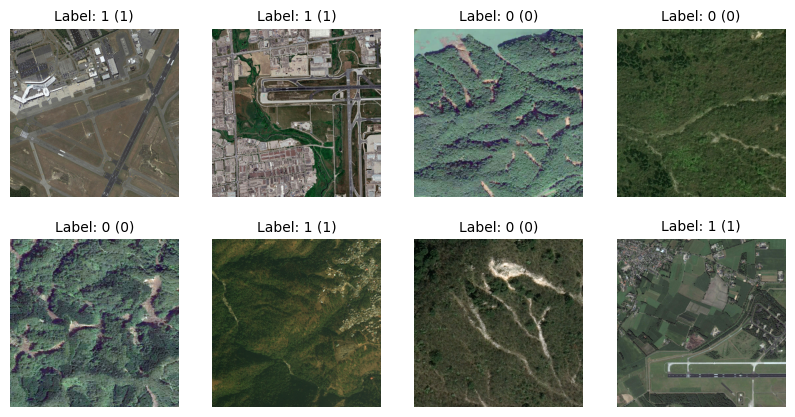

In [35]:
## Checking Images and Labels:
plt.figure(figsize=(10, 5))
for images, labels in train_dataset.take(1):  # Take one batch
    for i in range(8):  # Display first 6 samples
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = labels[i].numpy()
        label_name = class_names[label] if 'class_names' in locals() else label
        plt.title(f"Label: {label} ({label_name})", fontsize=10)
        plt.axis("off")
plt.show()

<hr style="border:8px solid #0a0849">

### **Class Weights for use during Model Fit**
- Added code to create Class Weights (class_weight=class_weight,) that you may use during the Model Fit process. 
- https://keras.io/examples/structured_data/imbalanced_classification/

In [36]:
# Assuming `train_dataset` is your dataset and you have class labels as `y_train`
class_labels = np.concatenate([y.numpy() for _, y in train_dataset])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Option to use 'balanced' or specify manual weights
    classes=np.unique(class_labels),
    y=class_labels
)

# Convert to a dictionary (Keras expects this format)
class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", class_weights_dict)

Class weights: {0: 1.1490939044481054, 1: 0.8851522842639594}


### Test Data

In [37]:
## Update path given the Google_Earth_Images/landslide vs. non-landslide directory structure. 
data_dir_test_lvltwo=pathlib.Path(data_dir_test) / 'Google_Earth_Images'
data_dir_test_lvltwo

PosixPath('/home/dms3gv/.keras/datasets/test_google_images_landslides_five/Google_Earth_Images')

In [38]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir_test_lvltwo,   # Base directory
    labels='inferred',           # Automatically assign labels based on folder names
    subset=None,                 # No split; we are directly specifying test data
    seed=512,                    # Random seed for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,  ### Add because the labels and images were getting mixed up in processing. 
    validation_split=None,       # No validation split; test data only
)

Found 142 files belonging to 2 classes.


# Model Testing

In [40]:
### Plot Helper
def visualize_model_results(model_input):
    acc = model_input.history['accuracy']
    val_acc = model_input.history['val_accuracy']

    loss = model_input.history['loss']
    val_loss = model_input.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2,1,2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

## ENB3

In [41]:
### Data Augmentation Helper
data_augmentation = keras.Sequential(
  [
    keras.layers.RandomRotation(factor=0.10),
    keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomContrast(factor=0.5),
    keras.layers.RandomBrightness(factor=.6),
      
    # layers.RandomSaturation(.7, seed=516) ## Error
    keras.layers.Lambda(lambda x: tf.image.random_saturation(x, lower=0.3, upper=1.2))
  ]
)

In [42]:
## Import EFB3 Model Weights
from tensorflow.keras.applications import EfficientNetB3

In [43]:
## Calc. the number of classes. 
land_class_num = len(folders)
land_class_num
# Setting up parameters for model. 
IMG_SIZE=300
learn_rate_land = .0001  ## For optimizer.

print(land_class_num) ## Check class number AND use as argument below.

2


In [44]:
# Create the base model from the pre-trained model EfficientNetB3.
def build_model(num_classes):
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    ### Adding Augmentation
    inputs = data_augmentation(inputs)  ## Added Line
    model = EfficientNetB3(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.20
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    # outputs = layers.Dense(1, activation="sigmoid", name="pred")(x) ## Use for Binary Cross Entropy

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=learn_rate_land)  ## originally 1e-2
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
        # optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

In [45]:
## Create Model
landslide_model_ENB3 = build_model(num_classes=land_class_num)
# landslide_model_ENB3 = build_model(num_classes=1) ## for when we use Sigmoid/Binary Cross Entropy

epochs = 4  # @param {type: "slider", min:8, max:80}
landslide_ENB3_hist = landslide_model_ENB3.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, class_weight=class_weights_dict)


Epoch 1/4


I0000 00:00:1733678619.698565  584393 cuda_dnn.cc:529] Loaded cuDNN version 90501
I0000 00:00:1733678621.875339  584391 service.cc:148] XLA service 0x7f73ec351ca0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733678621.875477  584391 service.cc:156]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2024-12-08 12:23:41.901471: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733678622.028259  584391 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


175/175 [==============================] - 27s 72ms/step - loss: 0.4543 - accuracy: 0.7887 - val_loss: 0.2822 - val_accuracy: 0.8931
Epoch 2/4
175/175 [==============================] - 11s 60ms/step - loss: 0.2422 - accuracy: 0.9007 - val_loss: 0.1775 - val_accuracy: 0.9319
Epoch 3/4
175/175 [==============================] - 11s 59ms/step - loss: 0.1817 - accuracy: 0.9285 - val_loss: 0.1389 - val_accuracy: 0.9462
Epoch 4/4
175/175 [==============================] - 11s 59ms/step - loss: 0.1518 - accuracy: 0.9414 - val_loss: 0.1152 - val_accuracy: 0.9534


### finetuning by layer

In [46]:
## Number of Layers to Open!!!
layer_open = 10
layer_open

10

In [47]:
## Update Model
def unfreeze_model(model, layer_num):   
    # We unfreeze the top XXX layers while leaving BatchNorm layers frozen
    for layer in model.layers[-layer_num:]: # note, if batch norm, still counts as a top X layer, so it will actually only train top XXX layers - # of batch norms
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )  
        # optimizer=optimizer, loss="binary_crossentropy", metrics=metrics_detail )  ## Rather than 'accuracy'

In [48]:
unfreeze_model(landslide_model_ENB3, layer_open)

# epochs = 10  # @param {type: "slider", min:4, max:10}
# EFB3_hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
# plot_hist(hist)

epochs = 4  # @param {type: "slider", min:8, max:80}
ENB3_hist_fine = landslide_model_ENB3.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, 
                                          class_weight=class_weights_dict)

Epoch 1/4


E0000 00:00:1733678677.740242  564197 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


175/175 [==============================] - 24s 71ms/step - loss: 0.1248 - accuracy: 0.9520 - val_loss: 0.0957 - val_accuracy: 0.9648
Epoch 2/4
175/175 [==============================] - 11s 62ms/step - loss: 0.1151 - accuracy: 0.9534 - val_loss: 0.0857 - val_accuracy: 0.9692
Epoch 3/4
175/175 [==============================] - 11s 60ms/step - loss: 0.0925 - accuracy: 0.9661 - val_loss: 0.0774 - val_accuracy: 0.9713
Epoch 4/4
175/175 [==============================] - 11s 60ms/step - loss: 0.0900 - accuracy: 0.9631 - val_loss: 0.0676 - val_accuracy: 0.9727


## RN50

In [49]:
from tensorflow.keras.applications import ResNet50

# Create the base model from the pre-trained model ResNet50.
def build_model(num_classes):
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    ### Adding Augmentation
    inputs = data_augmentation(inputs)  ## Added Line
    model = ResNet50(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.20
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    # outputs = layers.Dense(1, activation="sigmoid", name="pred")(x) ## Use for Binary Cross Entropy

    # Compile
    model = keras.Model(inputs, outputs, name="ResNet50")
    optimizer = keras.optimizers.Adam(learning_rate=learn_rate_land)  ## originally 1e-2
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
        # optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

In [50]:
## Create Model
landslide_model_RN50 = build_model(num_classes=land_class_num)

epochs = 4  # @param {type: "slider", min:8, max:80}
landslide_RN50_hist = landslide_model_RN50.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, class_weight=class_weights_dict)


Epoch 1/4
175/175 [==============================] - 14s 54ms/step - loss: 0.3751 - accuracy: 0.8391 - val_loss: 0.1730 - val_accuracy: 0.9455
Epoch 2/4
175/175 [==============================] - 8s 43ms/step - loss: 0.1577 - accuracy: 0.9389 - val_loss: 0.1067 - val_accuracy: 0.9613
Epoch 3/4
175/175 [==============================] - 8s 41ms/step - loss: 0.1149 - accuracy: 0.9538 - val_loss: 0.0838 - val_accuracy: 0.9677
Epoch 4/4
175/175 [==============================] - 8s 41ms/step - loss: 0.0920 - accuracy: 0.9652 - val_loss: 0.0698 - val_accuracy: 0.9749


In [51]:
unfreeze_model(landslide_model_RN50, layer_open)

# epochs = 10  # @param {type: "slider", min:4, max:10}
# EFB3_hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
# plot_hist(hist)

epochs = 4  # @param {type: "slider", min:8, max:80}
RN50_hist_fine = landslide_model_RN50.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, 
                                          class_weight=class_weights_dict)

Epoch 1/4
175/175 [==============================] - 15s 54ms/step - loss: 0.0709 - accuracy: 0.9728 - val_loss: 0.0569 - val_accuracy: 0.9799
Epoch 2/4
175/175 [==============================] - 8s 43ms/step - loss: 0.0643 - accuracy: 0.9789 - val_loss: 0.0492 - val_accuracy: 0.9849
Epoch 3/4
175/175 [==============================] - 8s 46ms/step - loss: 0.0507 - accuracy: 0.9821 - val_loss: 0.0417 - val_accuracy: 0.9857
Epoch 4/4
175/175 [==============================] - 8s 44ms/step - loss: 0.0417 - accuracy: 0.9878 - val_loss: 0.0369 - val_accuracy: 0.9892


## Prediction

### ENB3

In [52]:
print("Evaluate on test landslide images")
results = landslide_model_ENB3.evaluate(test_dataset)
print("test loss, test acc:", results)

Evaluate on test landslide images
5/5 [==============================] - 1s 81ms/step - loss: 1.0764 - accuracy: 0.6056
test loss, test acc: [1.0763651132583618, 0.6056337952613831]


In [53]:
# Get predictions and true labels
y_pred_probs = landslide_model_ENB3.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the class with the highest probability
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels

5/5 [==============================] - 2s 50ms/step


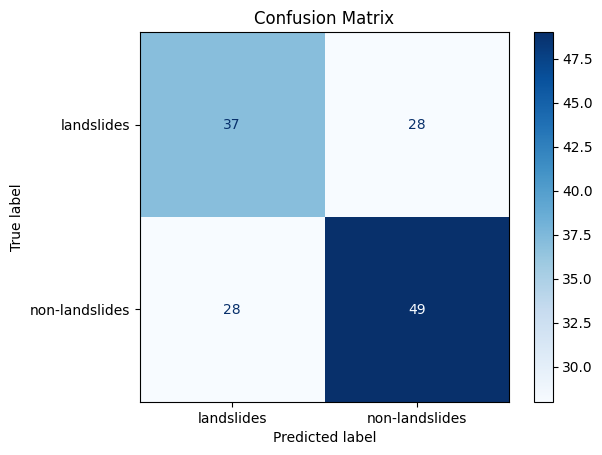

In [54]:
## Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [55]:
### Extract TP, TN, FP, FN - HH - Redesigned to make Landslides the TPs
# TN, FP, FN, TP = cm.ravel()
TP, FN, FP, TN = cm.ravel()
print(f"True Positives (TP): {TP}  False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP} True Negatives (TN): {TN}")
print('\n')
print(f'Accuracy: {round((TP+TN)/(TP+TN+FP+FN),3)}')
precision_val = round(TP/(TP+FP),3); #print(precision_val)
print(f'Precision: TP / (TP + FP) | Positive predictions are correct. {precision_val}')
recall_val = round(TP/(TP+FN),3); #print(recall_val)
print(f'Recall: TP / (TP + FN) | Actual positive cases are identified. {recall_val}')
F1_val = round(2*(precision_val*recall_val)/(precision_val+recall_val),3);  #print(F1_val)
print(f'F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. {F1_val}')

True Positives (TP): 37  False Negatives (FN): 28
False Positives (FP): 28 True Negatives (TN): 49


Accuracy: 0.606
Precision: TP / (TP + FP) | Positive predictions are correct. 0.569
Recall: TP / (TP + FN) | Actual positive cases are identified. 0.569
F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. 0.569


### RN50

In [56]:
print("Evaluate on test landslide images")
results = landslide_model_RN50.evaluate(test_dataset)
print("test loss, test acc:", results)

Evaluate on test landslide images
5/5 [==============================] - 1s 143ms/step - loss: 1.3535 - accuracy: 0.5493
test loss, test acc: [1.3534783124923706, 0.5492957830429077]


In [57]:
# Get predictions and true labels
y_pred_probs = landslide_model_RN50.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the class with the highest probability
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels

5/5 [==============================] - 2s 36ms/step


2024-12-08 12:26:49.021586: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


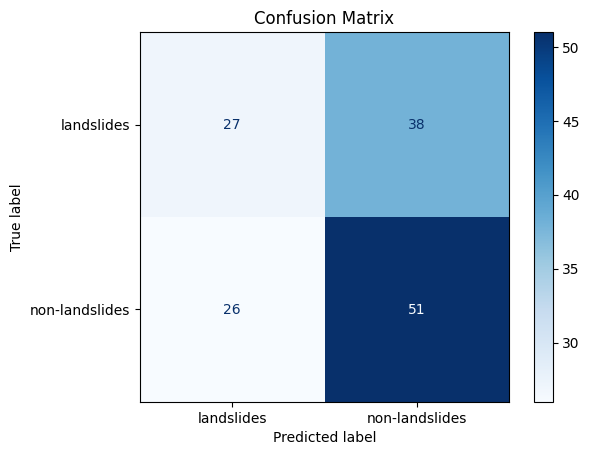

In [58]:
## Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [59]:
### Extract TP, TN, FP, FN - HH - Redesigned to make Landslides the TPs
# TN, FP, FN, TP = cm.ravel()
TP, FN, FP, TN = cm.ravel()
print(f"True Positives (TP): {TP}  False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP} True Negatives (TN): {TN}")
print('\n')
print(f'Accuracy: {round((TP+TN)/(TP+TN+FP+FN),3)}')
precision_val = round(TP/(TP+FP),3); #print(precision_val)
print(f'Precision: TP / (TP + FP) | Positive predictions are correct. {precision_val}')
recall_val = round(TP/(TP+FN),3); #print(recall_val)
print(f'Recall: TP / (TP + FN) | Actual positive cases are identified. {recall_val}')
F1_val = round(2*(precision_val*recall_val)/(precision_val+recall_val),3);  #print(F1_val)
print(f'F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. {F1_val}')

True Positives (TP): 27  False Negatives (FN): 38
False Positives (FP): 26 True Negatives (TN): 51


Accuracy: 0.549
Precision: TP / (TP + FP) | Positive predictions are correct. 0.509
Recall: TP / (TP + FN) | Actual positive cases are identified. 0.415
F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. 0.457


### Notes
RN-50 appears to have better training results, but performs worse on prediction.

### Review model architectures

In [60]:
landslide_model_ENB3.summary(show_trainable=True)

Model: "EfficientNet"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_2 (InputLayer)        [(None, 300, 300, 3)]        0         []                            Y          
                                                                                                             
 rescaling (Rescaling)       (None, 300, 300, 3)          0         ['input_2[0][0]']             N          
                                                                                                             
 normalization (Normalizati  (None, 300, 300, 3)          7         ['rescaling[1][0]']           N          
 on)                                                                                                         
                                                                                                  

In [61]:
landslide_model_RN50.summary(show_trainable=True)

Model: "ResNet50"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_4 (InputLayer)        [(None, 300, 300, 3)]        0         []                            Y          
                                                                                                             
 conv1_pad (ZeroPadding2D)   (None, 306, 306, 3)          0         ['input_4[0][0]']             N          
                                                                                                             
 conv1_conv (Conv2D)         (None, 150, 150, 64)         9472      ['conv1_pad[1][0]']           N          
                                                                                                             
 conv1_bn (BatchNormalizati  (None, 150, 150, 64)         256       ['conv1_conv[1][0]']          N   

# Finetuning By Block

In [63]:
## changed to include ability to go block by block (at least for ENB architecture)
def unfreeze_model(model, layer_num, by_blocks=False):
    
    if by_blocks:
        
        blocks = []
        current_block = []
        current_prefix = None

        for layer in model.layers:
            # NOTE: only works with ENB3 architecture, needs more logic for others
            block_prefix = layer.name.split("_")[0]

            if block_prefix != current_prefix:
                # Start a new block if the prefix changes
                if current_block:  # If there's an existing block, save it
                    blocks.append(current_block)
                current_block = []
                current_prefix = block_prefix

            # Add the current layer to the current block
            current_block.append(layer)

        # Add the final block
        if current_block:
            blocks.append(current_block)
            
        # Unfreeze all layers in the selected blocks (ignoring batchnorm)
        blocks_to_unfreeze = blocks[-layer_num:] # note: you will need to skip the first few tops
        for block in blocks_to_unfreeze:
            for layer in block:
                if not isinstance(layer, layers.BatchNormalization):
                    layer.trainable = True
                    print(f'Unfreezing: {layer.name}')
                    
    
    else:

        # We unfreeze the top XXX layers while leaving BatchNorm layers frozen
        # note: if batch norm, still counts as a top X layer, so it will actually only train top XXX layers - # of batch norms
        for layer in model.layers[-layer_num:]:
            if not isinstance(layer, layers.BatchNormalization):
                layer.trainable = True
                print(f'Unfreezing: {layer.name}')

    optimizer = keras.optimizers.Adam(learning_rate=1e-5) # note this may need to be changed when unfreezing
    
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )  
        # optimizer=optimizer, loss="binary_crossentropy", metrics=metrics_detail )  ## Rather than 'accuracy'

## ENB3

In [64]:
## restart model

In [65]:
# Create the base model from the pre-trained model EfficientNetB3.
def build_model(num_classes):
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    ### Adding Augmentation
    inputs = data_augmentation(inputs)  ## Added Line
    model = EfficientNetB3(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.20
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    # outputs = layers.Dense(1, activation="sigmoid", name="pred")(x) ## Use for Binary Cross Entropy

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=learn_rate_land)  ## originally 1e-2
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
        # optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

In [66]:
## Create Model
landslide_model_ENB3 = build_model(num_classes=land_class_num)
# landslide_model_ENB3 = build_model(num_classes=1) ## for when we use Sigmoid/Binary Cross Entropy

epochs = 4  # @param {type: "slider", min:8, max:80}
landslide_ENB3_hist = landslide_model_ENB3.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, class_weight=class_weights_dict)


Epoch 1/4
175/175 [==============================] - 24s 72ms/step - loss: 0.4166 - accuracy: 0.8174 - val_loss: 0.2493 - val_accuracy: 0.9032
Epoch 2/4
175/175 [==============================] - 11s 61ms/step - loss: 0.2245 - accuracy: 0.9052 - val_loss: 0.1726 - val_accuracy: 0.9333
Epoch 3/4
175/175 [==============================] - 11s 61ms/step - loss: 0.1755 - accuracy: 0.9278 - val_loss: 0.1406 - val_accuracy: 0.9440
Epoch 4/4
175/175 [==============================] - 11s 59ms/step - loss: 0.1514 - accuracy: 0.9405 - val_loss: 0.1188 - val_accuracy: 0.9534


In [67]:
unfreeze_model(landslide_model_ENB3, 6, by_blocks=True) #22 layers to capture last sub-block

# epochs = 10  # @param {type: "slider", min:4, max:10}
# EFB3_hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
# plot_hist(hist)

epochs = 4  # @param {type: "slider", min:8, max:80}
ENB3_hist_fine = landslide_model_ENB3.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, 
                                          class_weight=class_weights_dict)

Unfreezing: block7b_expand_conv
Unfreezing: block7b_expand_activation
Unfreezing: block7b_dwconv
Unfreezing: block7b_activation
Unfreezing: block7b_se_squeeze
Unfreezing: block7b_se_reshape
Unfreezing: block7b_se_reduce
Unfreezing: block7b_se_expand
Unfreezing: block7b_se_excite
Unfreezing: block7b_project_conv
Unfreezing: block7b_drop
Unfreezing: block7b_add
Unfreezing: top_conv
Unfreezing: top_activation
Unfreezing: avg_pool
Unfreezing: top_dropout
Unfreezing: pred
Epoch 1/4


E0000 00:00:1733679295.466454  564197 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


175/175 [==============================] - 26s 72ms/step - loss: 0.1212 - accuracy: 0.9522 - val_loss: 0.0845 - val_accuracy: 0.9641
Epoch 2/4
175/175 [==============================] - 11s 61ms/step - loss: 0.0839 - accuracy: 0.9708 - val_loss: 0.0768 - val_accuracy: 0.9684
Epoch 3/4
175/175 [==============================] - 11s 61ms/step - loss: 0.0812 - accuracy: 0.9688 - val_loss: 0.0599 - val_accuracy: 0.9749
Epoch 4/4
175/175 [==============================] - 11s 61ms/step - loss: 0.0643 - accuracy: 0.9765 - val_loss: 0.0527 - val_accuracy: 0.9785


### Predict

In [68]:
print("Evaluate on test landslide images")
results = landslide_model_ENB3.evaluate(test_dataset)
print("test loss, test acc:", results)

Evaluate on test landslide images
5/5 [==============================] - 0s 48ms/step - loss: 1.0518 - accuracy: 0.6197
test loss, test acc: [1.0518335103988647, 0.6197183132171631]


In [69]:
# Get predictions and true labels
y_pred_probs = landslide_model_ENB3.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the class with the highest probability
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels

5/5 [==============================] - 3s 65ms/step


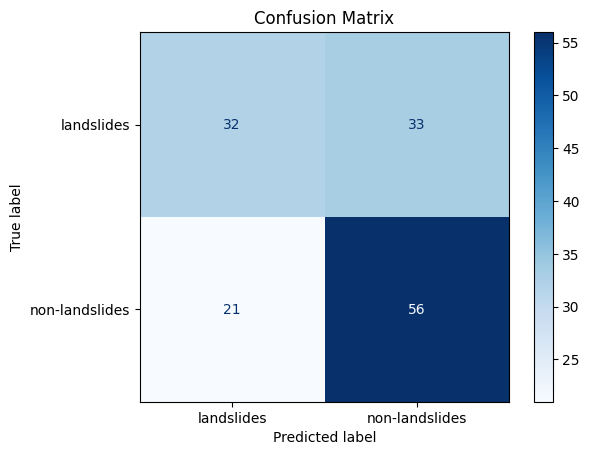

True Positives (TP): 32  False Negatives (FN): 33
False Positives (FP): 21 True Negatives (TN): 56


Accuracy: 0.62
Precision: TP / (TP + FP) | Positive predictions are correct. 0.604
Recall: TP / (TP + FN) | Actual positive cases are identified. 0.492
F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. 0.542


In [70]:
## Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### Extract TP, TN, FP, FN - HH - Redesigned to make Landslides the TPs
# TN, FP, FN, TP = cm.ravel()
TP, FN, FP, TN = cm.ravel()
print(f"True Positives (TP): {TP}  False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP} True Negatives (TN): {TN}")
print('\n')
print(f'Accuracy: {round((TP+TN)/(TP+TN+FP+FN),3)}')
precision_val = round(TP/(TP+FP),3); #print(precision_val)
print(f'Precision: TP / (TP + FP) | Positive predictions are correct. {precision_val}')
recall_val = round(TP/(TP+FN),3); #print(recall_val)
print(f'Recall: TP / (TP + FN) | Actual positive cases are identified. {recall_val}')
F1_val = round(2*(precision_val*recall_val)/(precision_val+recall_val),3);  #print(F1_val)
print(f'F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. {F1_val}')

### Notes
We slight improved accuracy in prediction once we unfreeze the entire last sub-block compared to just top 10 layers, though worse recall. May be a result of the data.

## RN50

In [71]:
from tensorflow.keras.applications import ResNet50

# Create the base model from the pre-trained model ResNet50.
def build_model(num_classes):
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    ### Adding Augmentation
    inputs = data_augmentation(inputs)  ## Added Line
    model = ResNet50(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.20
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    # outputs = layers.Dense(1, activation="sigmoid", name="pred")(x) ## Use for Binary Cross Entropy

    # Compile
    model = keras.Model(inputs, outputs, name="ResNet50")
    optimizer = keras.optimizers.Adam(learning_rate=learn_rate_land)  ## originally 1e-2
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
        # optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

In [72]:
## Create Model
landslide_model_RN50 = build_model(num_classes=land_class_num)

epochs = 4  # @param {type: "slider", min:8, max:80}
landslide_RN50_hist = landslide_model_RN50.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, class_weight=class_weights_dict)


Epoch 1/4
175/175 [==============================] - 12s 45ms/step - loss: 0.3600 - accuracy: 0.8432 - val_loss: 0.1731 - val_accuracy: 0.9340
Epoch 2/4
175/175 [==============================] - 7s 41ms/step - loss: 0.1518 - accuracy: 0.9391 - val_loss: 0.0939 - val_accuracy: 0.9656
Epoch 3/4
175/175 [==============================] - 8s 42ms/step - loss: 0.1146 - accuracy: 0.9514 - val_loss: 0.0694 - val_accuracy: 0.9778
Epoch 4/4
175/175 [==============================] - 8s 42ms/step - loss: 0.0919 - accuracy: 0.9667 - val_loss: 0.0577 - val_accuracy: 0.9785


In [73]:
unfreeze_model(landslide_model_RN50, 14) # 14 layers to train all of block 3, since model naming scheme is different

# epochs = 10  # @param {type: "slider", min:4, max:10}
# EFB3_hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
# plot_hist(hist)

epochs = 4  # @param {type: "slider", min:8, max:80}
RN50_hist_fine = landslide_model_RN50.fit(train_dataset, epochs=epochs, validation_data=valid_dataset, 
                                          class_weight=class_weights_dict)

Unfreezing: conv5_block3_1_conv
Unfreezing: conv5_block3_1_relu
Unfreezing: conv5_block3_2_conv
Unfreezing: conv5_block3_2_relu
Unfreezing: conv5_block3_3_conv
Unfreezing: conv5_block3_add
Unfreezing: conv5_block3_out
Unfreezing: avg_pool
Unfreezing: top_dropout
Unfreezing: pred
Epoch 1/4
175/175 [==============================] - 15s 55ms/step - loss: 0.0668 - accuracy: 0.9735 - val_loss: 0.0339 - val_accuracy: 0.9885
Epoch 2/4
175/175 [==============================] - 8s 46ms/step - loss: 0.0421 - accuracy: 0.9857 - val_loss: 0.0216 - val_accuracy: 0.9935
Epoch 3/4
175/175 [==============================] - 8s 46ms/step - loss: 0.0237 - accuracy: 0.9921 - val_loss: 0.0202 - val_accuracy: 0.9914
Epoch 4/4
175/175 [==============================] - 8s 44ms/step - loss: 0.0157 - accuracy: 0.9966 - val_loss: 0.0135 - val_accuracy: 0.9957


In [74]:
#landslide_model_RN50.summary(show_trainable=True)

### Predict

In [75]:
print("Evaluate on test landslide images")
results = landslide_model_RN50.evaluate(test_dataset)
print("test loss, test acc:", results)

Evaluate on test landslide images
5/5 [==============================] - 0s 44ms/step - loss: 1.6257 - accuracy: 0.5845
test loss, test acc: [1.6257412433624268, 0.5845070481300354]


In [76]:
# Get predictions and true labels
y_pred_probs = landslide_model_RN50.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the class with the highest probability
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels

5/5 [==============================] - 1s 49ms/step


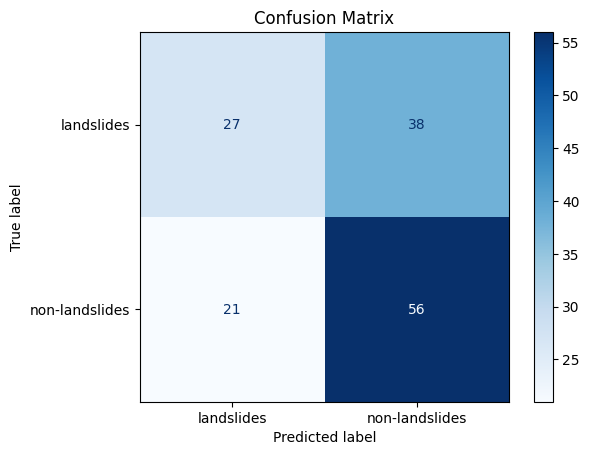

True Positives (TP): 27  False Negatives (FN): 38
False Positives (FP): 21 True Negatives (TN): 56


Accuracy: 0.585
Precision: TP / (TP + FP) | Positive predictions are correct. 0.562
Recall: TP / (TP + FN) | Actual positive cases are identified. 0.415
F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. 0.477


In [77]:
## Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### Extract TP, TN, FP, FN - HH - Redesigned to make Landslides the TPs
# TN, FP, FN, TP = cm.ravel()
TP, FN, FP, TN = cm.ravel()
print(f"True Positives (TP): {TP}  False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP} True Negatives (TN): {TN}")
print('\n')
print(f'Accuracy: {round((TP+TN)/(TP+TN+FP+FN),3)}')
precision_val = round(TP/(TP+FP),3); #print(precision_val)
print(f'Precision: TP / (TP + FP) | Positive predictions are correct. {precision_val}')
recall_val = round(TP/(TP+FN),3); #print(recall_val)
print(f'Recall: TP / (TP + FN) | Actual positive cases are identified. {recall_val}')
F1_val = round(2*(precision_val*recall_val)/(precision_val+recall_val),3);  #print(F1_val)
print(f'F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. {F1_val}')

### Notes
Although we see much higher validation accuracy than the same approach with ENB3, overall prediction performance is considerably worse. ENB3 is advertized as better suited for this specific kind of high quality satellite data, so a more generic RN50 may not be well-suited to go from generalized to task-specific in this case.

# Training on Combined Dataset

## Setup datasets

In [78]:
# combined test set
combined_dataset_url = 'https://dl.dropboxusercontent.com/scl/fi/sy3duklriddl3fo668as8/ls_model_data_six_combined_v2.zip?rlkey=chgywsbsn3ny0m2vrllll8icx&dl=0?raw=1'

In [79]:
from urllib.parse import urlparse
file_name = os.path.basename(urlparse(combined_dataset_url).path)
base_name = os.path.splitext(file_name)[0]

In [80]:
dataset_name = base_name
savepath = os.path.join(os.path.expanduser("~"), ".keras", "datasets", dataset_name)
savepath

'/home/dms3gv/.keras/datasets/ls_model_data_six_combined_v2'

In [81]:
data_dir_combined = tf.keras.utils.get_file(file_name, origin=combined_dataset_url, extract=True,
                                       #cache_dir = savepath
                                       )
data_dir_combined = pathlib.Path(data_dir_combined).with_suffix('')

In [82]:
data_dir_combined

PosixPath('/home/dms3gv/.keras/datasets/ls_model_data_six_combined_v2')

In [83]:
## Set Batch and Image size. 
batch_size = 32
img_height = 300
img_width = 300

#### Create Training / Validation Sets

In [84]:
## Set Training Set image set. 
train_dataset_combined = tf.keras.utils.image_dataset_from_directory(
  data_dir_combined,
  validation_split=0.20,
  subset="training",
  seed=512,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7135 files belonging to 2 classes.
Using 5708 files for training.


In [85]:
## Setup Valiation set.
valid_dataset_combined = tf.keras.utils.image_dataset_from_directory(
  data_dir_combined,
  validation_split=0.20,
  subset="validation",
  seed=512,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7135 files belonging to 2 classes.
Using 1427 files for validation.


In [86]:
# Assuming `train_dataset` is your dataset and you have class labels as `y_train`
class_labels = np.concatenate([y.numpy() for _, y in train_dataset_combined])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Option to use 'balanced' or specify manual weights
    classes=np.unique(class_labels),
    y=class_labels
)

# Convert to a dictionary (Keras expects this format)
combined_class_weights_dict = dict(enumerate(class_weights))

print("Class weights:", combined_class_weights_dict)

Class weights: {0: 1.1402317219336795, 1: 0.8904836193447738}


In [88]:
from tensorflow.keras.applications import EfficientNetB3

# Setting up parameters for model. 
land_class_num = 2
IMG_SIZE=300
learn_rate_land = .00005  ## For optimizer. # dropped from 1e-4

### Notes
Increased epochs and dropped Learning Rate down, as it may compensate for the unfrozen layers

## Train Models

In [89]:
### Data Augmentation Helper
data_augmentation = keras.Sequential(
  [
    keras.layers.RandomRotation(factor=0.10),
    keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomContrast(factor=0.5),
    keras.layers.RandomBrightness(factor=.6),
      
    # layers.RandomSaturation(.7, seed=516) ## Error
    keras.layers.Lambda(lambda x: tf.image.random_saturation(x, lower=0.3, upper=1.2))
  ]
)

In [90]:

# Create the base model from the pre-trained model EfficientNetB3.
def build_model(num_classes):
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    ### Adding Augmentation
    inputs = data_augmentation(inputs)  ## Added Line
    model = EfficientNetB3(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.20
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    # outputs = layers.Dense(1, activation="sigmoid", name="pred")(x) ## Use for Binary Cross Entropy

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=learn_rate_land)  ## originally 1e-2
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
        # optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

In [91]:
## Create Model
landslide_model_ENB3 = build_model(num_classes=2)
# landslide_model_ENB3 = build_model(num_classes=1) ## for when we use Sigmoid/Binary Cross Entropy

epochs = 10  # @param {type: "slider", min:8, max:80}
landslide_ENB3_hist = landslide_model_ENB3.fit(train_dataset_combined, epochs=epochs, validation_data=valid_dataset_combined, class_weight=combined_class_weights_dict)


Epoch 1/10
179/179 [==============================] - 27s 80ms/step - loss: 0.6233 - accuracy: 0.7206 - val_loss: 0.3935 - val_accuracy: 0.8388
Epoch 2/10
179/179 [==============================] - 11s 59ms/step - loss: 0.3758 - accuracy: 0.8432 - val_loss: 0.2948 - val_accuracy: 0.8732
Epoch 3/10
179/179 [==============================] - 11s 59ms/step - loss: 0.2910 - accuracy: 0.8793 - val_loss: 0.2466 - val_accuracy: 0.8942
Epoch 4/10
179/179 [==============================] - 11s 59ms/step - loss: 0.2359 - accuracy: 0.9056 - val_loss: 0.2113 - val_accuracy: 0.9075
Epoch 5/10
179/179 [==============================] - 11s 61ms/step - loss: 0.2165 - accuracy: 0.9131 - val_loss: 0.1880 - val_accuracy: 0.9166
Epoch 6/10
179/179 [==============================] - 11s 59ms/step - loss: 0.1956 - accuracy: 0.9166 - val_loss: 0.1734 - val_accuracy: 0.9257
Epoch 7/10
179/179 [==============================] - 11s 60ms/step - loss: 0.1752 - accuracy: 0.9304 - val_loss: 0.1574 - val_accuracy:

In [25]:
## finetuning with first block unfrozen
landslide_model_ENB3_tuned = build_model(num_classes=2) # start over from base ENB3, previous approach lead to overfitting
unfreeze_model(landslide_model_ENB3_tuned, 6, by_blocks=True)

Unfreezing: block7b_expand_conv
Unfreezing: block7b_expand_activation
Unfreezing: block7b_dwconv
Unfreezing: block7b_activation
Unfreezing: block7b_se_squeeze
Unfreezing: block7b_se_reshape
Unfreezing: block7b_se_reduce
Unfreezing: block7b_se_expand
Unfreezing: block7b_se_excite
Unfreezing: block7b_project_conv
Unfreezing: block7b_drop
Unfreezing: block7b_add
Unfreezing: top_conv
Unfreezing: top_activation
Unfreezing: avg_pool
Unfreezing: top_dropout
Unfreezing: pred


In [26]:
epochs = 10  # @param {type: "slider", min:8, max:80}
landslide_ENB3_tuned_hist = landslide_model_ENB3_tuned.fit(train_dataset_combined, epochs=epochs, validation_data=valid_dataset_combined, class_weight=combined_class_weights_dict)

Epoch 1/10


E0000 00:00:1733601065.544673  188741 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNet/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


179/179 [==============================] - 33s 104ms/step - loss: 0.4598 - accuracy: 0.7943 - val_loss: 0.3074 - val_accuracy: 0.8760
Epoch 2/10
179/179 [==============================] - 16s 88ms/step - loss: 0.2342 - accuracy: 0.9045 - val_loss: 0.1770 - val_accuracy: 0.9327
Epoch 3/10
179/179 [==============================] - 16s 88ms/step - loss: 0.1708 - accuracy: 0.9262 - val_loss: 0.1438 - val_accuracy: 0.9432
Epoch 4/10
179/179 [==============================] - 16s 88ms/step - loss: 0.1516 - accuracy: 0.9396 - val_loss: 0.1088 - val_accuracy: 0.9622
Epoch 5/10
179/179 [==============================] - 16s 88ms/step - loss: 0.1216 - accuracy: 0.9546 - val_loss: 0.1023 - val_accuracy: 0.9643
Epoch 6/10
179/179 [==============================] - 16s 88ms/step - loss: 0.1123 - accuracy: 0.9573 - val_loss: 0.0931 - val_accuracy: 0.9720
Epoch 7/10
179/179 [==============================] - 16s 88ms/step - loss: 0.0893 - accuracy: 0.9685 - val_loss: 0.0827 - val_accuracy: 0.9755
Ep

## Eval on separate test

### setup new test data

In [27]:
#https://www.dropbox.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0
# test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0?raw=1"

#test_dataset_url = 'https://dl.dropboxusercontent.com/s/0en4k86c1r1uzs0/test_google_images_landslides_four.zip?st=pdg6yhzj&dl=0?raw=1'
test_dataset_url = 'https://dl.dropboxusercontent.com/scl/fi/a8evtoop10e9cadnxorqw/google_earth_unique_test.zip?rlkey=g463zbw32hn5ez80wb1qogw4g&dl=0?raw=1'

In [28]:
from urllib.parse import urlparse
file_name = os.path.basename(urlparse(test_dataset_url).path)
base_name = os.path.splitext(file_name)[0]

In [29]:
dataset_name = base_name
savepath = os.path.join(os.path.expanduser("~"), ".keras", "datasets", dataset_name)
savepath

'/home/dms3gv/.keras/datasets/google_earth_unique_test'

In [30]:
data_dir_test = tf.keras.utils.get_file(file_name, origin=test_dataset_url, extract=True,
                                       #cache_dir = savepath
                                       )
data_dir_test = pathlib.Path(data_dir_test).with_suffix('')

In [31]:
data_dir_test

PosixPath('/home/dms3gv/.keras/datasets/google_earth_unique_test')

In [32]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,   # Base directory
    labels='inferred',           # Automatically assign labels based on folder names
    subset=None,                 # No split; we are directly specifying test data
    seed=512,                    # Random seed for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,  ### Add because the labels and images were getting mixed up in processing. 
    validation_split=None,       # No validation split; test data only
)

Found 62 files belonging to 2 classes.


### predict

In [33]:
print("Evaluate on test landslide images")
results = landslide_model_ENB3_tuned.evaluate(test_dataset)
print("test loss, test acc:", results)

Evaluate on test landslide images
2/2 [==============================] - 0s 146ms/step - loss: 0.5651 - accuracy: 0.8065
test loss, test acc: [0.5650883913040161, 0.8064516186714172]


In [34]:
# Get predictions and true labels
y_pred_probs = landslide_model_ENB3_tuned.predict(test_dataset)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the class with the highest probability
y_true = np.concatenate([y for x, y in test_dataset], axis=0)  # Extract true labels

2/2 [==============================] - 2s 102ms/step


2024-12-07 15:27:09.105350: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


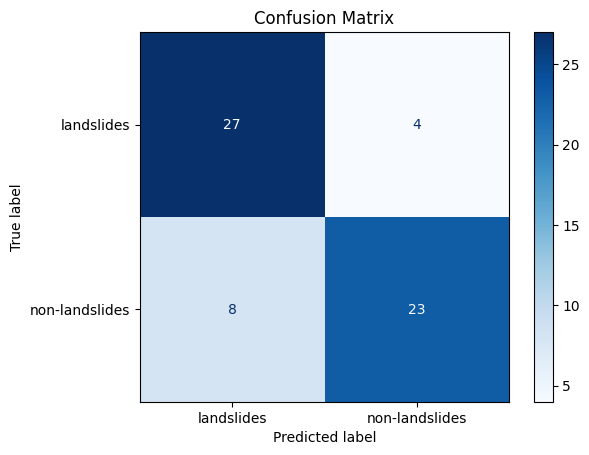

In [35]:
## Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [36]:
### Extract TP, TN, FP, FN - HH - Redesigned to make Landslides the TPs
# TN, FP, FN, TP = cm.ravel()
TP, FN, FP, TN = cm.ravel()
print(f"True Positives (TP): {TP}  False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP} True Negatives (TN): {TN}")
print('\n')
print(f'Accuracy: {round((TP+TN)/(TP+TN+FP+FN),3)}')
precision_val = round(TP/(TP+FP),3); #print(precision_val)
print(f'Precision: TP / (TP + FP) | Positive predictions are correct. {precision_val}')
recall_val = round(TP/(TP+FN),3); #print(recall_val)
print(f'Recall: TP / (TP + FN) | Actual positive cases are identified. {recall_val}')
F1_val = round(2*(precision_val*recall_val)/(precision_val+recall_val),3);  #print(F1_val)
print(f'F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. {F1_val}')

True Positives (TP): 27  False Negatives (FN): 4
False Positives (FP): 8 True Negatives (TN): 23


Accuracy: 0.806
Precision: TP / (TP + FP) | Positive predictions are correct. 0.771
Recall: TP / (TP + FN) | Actual positive cases are identified. 0.871
F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. 0.818


### Notes
found better results by directly fine-tuning base ENB3, was likely running into overfitting with previous approach

# Deeper ENB

**Note: larger ENB does not guarantee improved performance when dataset is small**

## Resize Image Data
other versions of ENB require higher res

In [108]:
## Set Batch and Image size. # be sure to change depending on ENB used
batch_size = 32
img_height = 380
img_width = 380

#### Create Training / Validation Sets

In [109]:
## Set Training Set image set. 
train_dataset_combined2 = tf.keras.utils.image_dataset_from_directory(
  data_dir_combined,
  validation_split=0.20,
  subset="training",
  seed=512,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7135 files belonging to 2 classes.
Using 5708 files for training.


In [110]:
## Setup Valiation set.
valid_dataset_combined2 = tf.keras.utils.image_dataset_from_directory(
  data_dir_combined,
  validation_split=0.20,
  subset="validation",
  seed=512,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 7135 files belonging to 2 classes.
Using 1427 files for validation.


In [111]:
# Assuming `train_dataset` is your dataset and you have class labels as `y_train`
class_labels = np.concatenate([y.numpy() for _, y in train_dataset_combined2])

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',  # Option to use 'balanced' or specify manual weights
    classes=np.unique(class_labels),
    y=class_labels
)

# Convert to a dictionary (Keras expects this format)
combined_class_weights_dict2 = dict(enumerate(class_weights))

print("Class weights:", combined_class_weights_dict2)

Class weights: {0: 1.1402317219336795, 1: 0.8904836193447738}


## Setup Model
Trying B4, which is deeper (258 vs 210)

In [112]:
from tensorflow.keras.applications import EfficientNetB4

# Setting up parameters for model. 
land_class_num = 2
IMG_SIZE=380 # change res depending on model
learn_rate_land = .00005  ## For optimizer.

In [113]:
### Data Augmentation Helper
data_augmentation = keras.Sequential(
  [
    keras.layers.RandomRotation(factor=0.10),
    keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomContrast(factor=0.5),
    keras.layers.RandomBrightness(factor=.6),
      
    # layers.RandomSaturation(.7, seed=516) ## Error
    keras.layers.Lambda(lambda x: tf.image.random_saturation(x, lower=0.3, upper=1.2))
  ]
)

In [115]:

# Create the base model from the pre-trained model EfficientNetB4.
def build_model(num_classes):
    
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    ### Adding Augmentation
    inputs = data_augmentation(inputs)  ## Added Line
    model = EfficientNetB4(include_top=False, input_tensor=inputs, weights="imagenet") # changed to B4

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.20
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    # outputs = layers.Dense(1, activation="sigmoid", name="pred")(x) ## Use for Binary Cross Entropy

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNetB4")
    optimizer = keras.optimizers.Adam(learning_rate=learn_rate_land)  ## originally 1e-2
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
        # optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"]
    )
    return model

In [116]:
## Update Model
def unfreeze_model(model, layer_num, by_blocks=False):
    
    if by_blocks:
        
        blocks = []
        current_block = []
        current_prefix = None

        for layer in model.layers:
            # NOTE: only works with ENB3 architecture, needs more logic for others
            block_prefix = layer.name.split("_")[0]

            if block_prefix != current_prefix:
                # Start a new block if the prefix changes
                if current_block:  # If there's an existing block, save it
                    blocks.append(current_block)
                current_block = []
                current_prefix = block_prefix

            # Add the current layer to the current block
            current_block.append(layer)

        # Add the final block
        if current_block:
            blocks.append(current_block)
            
        # Unfreeze all layers in the selected blocks (ignoring batchnorm)
        blocks_to_unfreeze = blocks[-layer_num:] # note: you will need to skip the first few tops
        for block in blocks_to_unfreeze:
            for layer in block:
                if not isinstance(layer, layers.BatchNormalization):
                    layer.trainable = True
                    print(f'Unfreezing: {layer.name}')
                    
    
    else:

        # We unfreeze the top XXX layers while leaving BatchNorm layers frozen
        # note: if batch norm, still counts as a top X layer, so it will actually only train top XXX layers - # of batch norms
        for layer in model.layers[-layer_num:]:
            if not isinstance(layer, layers.BatchNormalization):
                layer.trainable = True
                print(f'Unfreezing: {layer.name}')

    optimizer = keras.optimizers.Adam(learning_rate=1e-5) # note this may need to be changed when unfreezing
    
    model.compile(
        # optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"] )  
        # optimizer=optimizer, loss="binary_crossentropy", metrics=metrics_detail )  ## Rather than 'accuracy'

In [117]:
## Create Model
landslide_model_ENB4 = build_model(num_classes=2)
# landslide_model_ENB3 = build_model(num_classes=1) ## for when we use Sigmoid/Binary Cross Entropy

epochs = 10  # @param {type: "slider", min:8, max:80}
landslide_ENB4_hist = landslide_model_ENB4.fit(train_dataset_combined2, epochs=epochs, validation_data=valid_dataset_combined2, class_weight=combined_class_weights_dict2)


Epoch 1/10
179/179 [==============================] - 38s 132ms/step - loss: 0.4849 - accuracy: 0.7756 - val_loss: 0.3281 - val_accuracy: 0.8725
Epoch 2/10
179/179 [==============================] - 21s 115ms/step - loss: 0.2943 - accuracy: 0.8763 - val_loss: 0.2296 - val_accuracy: 0.8984
Epoch 3/10
179/179 [==============================] - 21s 114ms/step - loss: 0.2331 - accuracy: 0.9033 - val_loss: 0.1943 - val_accuracy: 0.9103
Epoch 4/10
179/179 [==============================] - 21s 115ms/step - loss: 0.1919 - accuracy: 0.9185 - val_loss: 0.1690 - val_accuracy: 0.9271
Epoch 5/10
179/179 [==============================] - 21s 115ms/step - loss: 0.1827 - accuracy: 0.9276 - val_loss: 0.1525 - val_accuracy: 0.9355
Epoch 6/10
179/179 [==============================] - 21s 114ms/step - loss: 0.1580 - accuracy: 0.9382 - val_loss: 0.1405 - val_accuracy: 0.9439
Epoch 7/10
179/179 [==============================] - 22s 124ms/step - loss: 0.1422 - accuracy: 0.9452 - val_loss: 0.1289 - val_ac

In [119]:
## finetuning with first block unfrozen
landslide_model_ENB4_tuned = build_model(num_classes=2)
unfreeze_model(landslide_model_ENB4_tuned, 6, by_blocks=True)

Unfreezing: block7b_expand_conv
Unfreezing: block7b_expand_activation
Unfreezing: block7b_dwconv
Unfreezing: block7b_activation
Unfreezing: block7b_se_squeeze
Unfreezing: block7b_se_reshape
Unfreezing: block7b_se_reduce
Unfreezing: block7b_se_expand
Unfreezing: block7b_se_excite
Unfreezing: block7b_project_conv
Unfreezing: block7b_drop
Unfreezing: block7b_add
Unfreezing: top_conv
Unfreezing: top_activation
Unfreezing: avg_pool
Unfreezing: top_dropout
Unfreezing: pred


In [120]:
epochs = 10  # @param {type: "slider", min:8, max:80}
landslide_ENB4_tuned_hist = landslide_model_ENB4_tuned.fit(train_dataset_combined2, epochs=epochs, validation_data=valid_dataset_combined2, class_weight=combined_class_weights_dict2)

Epoch 1/10


E0000 00:00:1733681844.285715  564197 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inEfficientNetB4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


179/179 [==============================] - 41s 143ms/step - loss: 0.3382 - accuracy: 0.8429 - val_loss: 0.2645 - val_accuracy: 0.8970
Epoch 2/10
179/179 [==============================] - 21s 117ms/step - loss: 0.1907 - accuracy: 0.9196 - val_loss: 0.1549 - val_accuracy: 0.9355
Epoch 3/10
179/179 [==============================] - 22s 121ms/step - loss: 0.1466 - accuracy: 0.9403 - val_loss: 0.1222 - val_accuracy: 0.9495
Epoch 4/10
179/179 [==============================] - 21s 117ms/step - loss: 0.1199 - accuracy: 0.9552 - val_loss: 0.0984 - val_accuracy: 0.9629
Epoch 5/10
179/179 [==============================] - 22s 118ms/step - loss: 0.1071 - accuracy: 0.9595 - val_loss: 0.0850 - val_accuracy: 0.9706
Epoch 6/10
179/179 [==============================] - 21s 118ms/step - loss: 0.0929 - accuracy: 0.9623 - val_loss: 0.0824 - val_accuracy: 0.9720
Epoch 7/10
179/179 [==============================] - 22s 118ms/step - loss: 0.0819 - accuracy: 0.9704 - val_loss: 0.0762 - val_accuracy: 0.9

## Eval on separate test

### setup test data

In [121]:
#https://www.dropbox.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0
# test_dataset_url = "https://dl.dropboxusercontent.com/scl/fi/nyv6xg7u0lj5uv5jtglto/test_google_images_landslide_three.zip?rlkey=b7xnjid2s7zvfjbp0oqtji084&dl=0?raw=1"

#test_dataset_url = 'https://dl.dropboxusercontent.com/s/0en4k86c1r1uzs0/test_google_images_landslides_four.zip?st=pdg6yhzj&dl=0?raw=1'
test_dataset_url = 'https://dl.dropboxusercontent.com/scl/fi/a8evtoop10e9cadnxorqw/google_earth_unique_test.zip?rlkey=g463zbw32hn5ez80wb1qogw4g&dl=0?raw=1'

In [122]:
from urllib.parse import urlparse
file_name = os.path.basename(urlparse(test_dataset_url).path)
base_name = os.path.splitext(file_name)[0]

In [123]:
dataset_name = base_name
savepath = os.path.join(os.path.expanduser("~"), ".keras", "datasets", dataset_name)
savepath

'/home/dms3gv/.keras/datasets/google_earth_unique_test'

In [124]:
data_dir_test = tf.keras.utils.get_file(file_name, origin=test_dataset_url, extract=True,
                                       #cache_dir = savepath
                                       )
data_dir_test = pathlib.Path(data_dir_test).with_suffix('')

In [125]:
data_dir_test

PosixPath('/home/dms3gv/.keras/datasets/google_earth_unique_test')

In [126]:
test_dataset2 = tf.keras.utils.image_dataset_from_directory(
    data_dir_test,   # Base directory
    labels='inferred',           # Automatically assign labels based on folder names
    subset=None,                 # No split; we are directly specifying test data
    seed=512,                    # Random seed for reproducibility
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,  ### Add because the labels and images were getting mixed up in processing. 
    validation_split=None,       # No validation split; test data only
)

Found 62 files belonging to 2 classes.


### predict

In [127]:
print("Evaluate on test landslide images")
results = landslide_model_ENB4_tuned.evaluate(test_dataset2)
print("test loss, test acc:", results)

Evaluate on test landslide images
2/2 [==============================] - 0s 154ms/step - loss: 0.7118 - accuracy: 0.7419
test loss, test acc: [0.7117786407470703, 0.7419354915618896]


In [128]:
# Get predictions and true labels
y_pred_probs = landslide_model_ENB4_tuned.predict(test_dataset2)  # Predict probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Get the class with the highest probability
y_true = np.concatenate([y for x, y in test_dataset2], axis=0)  # Extract true labels

2/2 [==============================] - 3s 89ms/step


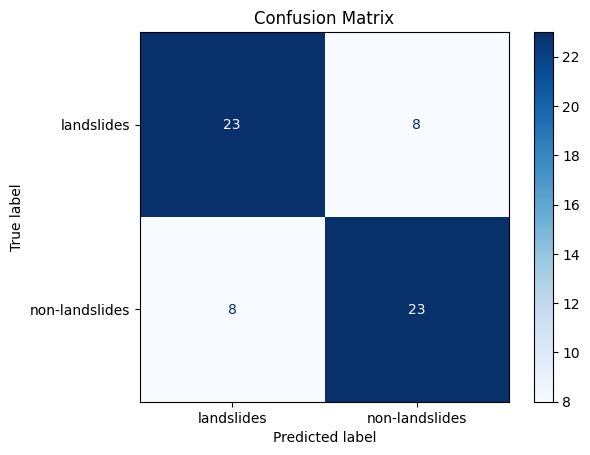

In [129]:
## Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset2.class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [131]:
### Extract TP, TN, FP, FN - HH - Redesigned to make Landslides the TPs
# TN, FP, FN, TP = cm.ravel()
TP, FN, FP, TN = cm.ravel()
print(f"True Positives (TP): {TP}  False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP} True Negatives (TN): {TN}")
print('\n')
print(f'Accuracy: {round((TP+TN)/(TP+TN+FP+FN),3)}')
precision_val = round(TP/(TP+FP),3); #print(precision_val)
print(f'Precision: TP / (TP + FP) | Positive predictions are correct. {precision_val}')
recall_val = round(TP/(TP+FN),3); #print(recall_val)
print(f'Recall: TP / (TP + FN) | Actual positive cases are identified. {recall_val}')
F1_val = round(2*(precision_val*recall_val)/(precision_val+recall_val),3);  #print(F1_val)
print(f'F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. {F1_val}')

True Positives (TP): 23  False Negatives (FN): 8
False Positives (FP): 8 True Negatives (TN): 23


Accuracy: 0.742
Precision: TP / (TP + FP) | Positive predictions are correct. 0.742
Recall: TP / (TP + FN) | Actual positive cases are identified. 0.742
F1 Score: 2 * (Precision * Recall) / (Precision + Recall) | Balance Measurement. 0.742


## Notes
Deeper doesn't necessarily mean better. May be running into issues with overfitting. Training is much slower as expected, likely not worthwhile.

# Further Notes On Experiments
Fine-tuning around model-specific architecture, where models are often built in blocks, rather than at arbitrary layers, appears to show better results. Should be careful about overfitting. Lowering learning rate can help. For now, pursue using ENB3 with top block unfrozen.
Should also make considerations about training data. May have had issues with training data being too homogenous. Introducing images arbitrarily from Google Earth helps.